2021-08-05 08:11:57.209714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-05 08:11:57.209778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



df.shape: (3020, 4)
df.describe():               price    market_cap  total_volume
count   3020.000000  3.020000e+03  3.020000e+03
mean    6987.609566  1.261429e+11  1.089700e+10
std    11592.438130  2.166126e+11  1.804193e+10
min       67.809000  7.713681e+08  0.000000e+00
25%      432.636250  6.314506e+09  7.437963e+07
50%     2508.303947  4.122499e+10  1.648334e+09
75%     8698.408885  1.532166e+11  1.885325e+10
max    63576.676041  1.187737e+12  1.788941e+11
df.head():                  snapped_at   price    market_cap  total_volume
0 2013-04-28 00:00:00+00:00  135.30  1.500518e+09           0.0
1 2013-04-29 00:00:00+00:00  141.96  1.575032e+09           0.0
2 2013-04-30 00:00:00+00:00  135.30  1.501657e+09           0.0
3 2013-05-01 00:00:00+00:00  117.00  1.298952e+09           0.0
4 2013-05-02 00:00:00+00:00  103.43  1.148668e+09           0.0
df.tail():                     snapped_at         price    market_cap  total_volume
3015 2021-08-01 00:00:00+00:00  41754.166604  7.84039

2021-08-05 08:12:09.854422: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-05 08:12:09.864473: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-08-05 08:12:09.864522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thomas-Inspiron): /proc/driver/nvidia/version does not exist
2021-08-05 08:12:09.865383: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-05 08:12:13.129005: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-05 08:12:13.129562: I tensorflow/core/profiler/li

 1/23 [>.............................] - ETA: 5:29 - loss: 0.2136

2021-08-05 08:12:28.979989: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-05 08:12:28.980519: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/23 [=>............................] - ETA: 1:09 - loss: 0.1996

2021-08-05 08:12:31.832259: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-05 08:12:32.222315: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-05 08:12:32.691828: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2021_08_05_08_12_32
2021-08-05 08:12:32.938802: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_08_05_08_12_32/thomas-Inspiron.trace.json.gz
2021-08-05 08:12:33.059017: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2021_08_05_08_12_32
2021-08-05 08:12:33.059210: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2021_08_05_08_12_32/thomas-Inspiron.memory_profile.json.gz
2021-08-05 08:12:33.06246

23/23 [==============================] - 50s 2s/step - loss: 0.0604 - val_loss: 0.0756

Epoch 00001: loss improved from inf to 0.06042, saving model to weights.h5


2021-08-05 08:13:03.842594: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-05 08:13:03.842756: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-05 08:13:03.843152: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


 1/23 [>.............................] - ETA: 2:40 - loss: 0.1947

2021-08-05 08:13:11.773013: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-05 08:13:11.773052: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/23 [=>............................] - ETA: 37s - loss: 0.1846 

2021-08-05 08:13:13.679492: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-05 08:13:13.907353: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-05 08:13:14.239869: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2021_08_05_08_13_13
2021-08-05 08:13:14.435747: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_08_05_08_13_13/thomas-Inspiron.trace.json.gz
2021-08-05 08:13:14.542944: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2021_08_05_08_13_13
2021-08-05 08:13:14.543111: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2021_08_05_08_13_13/thomas-Inspiron.memory_profile.json.gz
2021-08-05 08:13:14.54554

23/23 [==============================] - 41s 2s/step - loss: 0.0497

Epoch 00001: loss improved from inf to 0.04965, saving model to weights.h5
0.46494377
0.46443197
0.46591392
0.46736923
0.46718788
0.4659593
0.4645495
0.46359572
0.4624437
0.46136424
0.4601693
0.45840293
0.45589516
0.45310616
0.4504686
0.4483034
0.44637248
0.44461113
0.44389677
0.44237682
0.44025725
0.43819895
0.43742895
0.43568286
0.43531227
0.43509707
0.43446168
0.43368265
0.43299845
0.43277502
0.43214503
0.43195412
0.43173674
0.43167287
0.4314306
0.43033952
0.42922372
0.42792907
0.42754397
0.42735025
0.42705604
0.42638022
0.42636737
0.4260161
0.4257884
0.4251997
0.42475438
0.42360106
0.42253354
0.42171425
0.42159563
0.4215009
0.42131022
0.42088017
0.42048326
0.420202
0.4198455
0.419615
0.4195243
0.41962
0.41981387
0.4202799
0.42063925
0.42024827
0.42028058
0.4202778
0.42028594
0.4201087
0.42016873
0.42018953
0.41990778
0.41960016
0.41955778
0.41888225
0.41883394
0.41796404
0.41775015
0.41741383
0.41726238
0.41661853

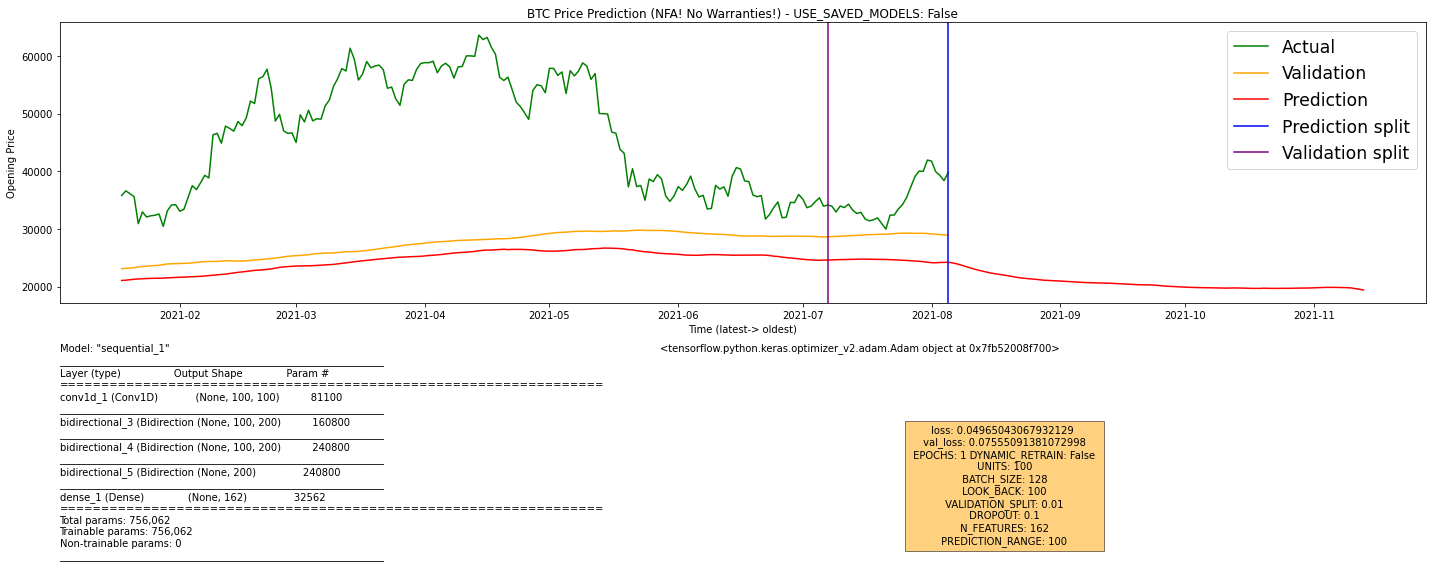

In [1]:
!pip install pandas==1.3.1

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# %matplotlib inline
import tensorflow
from matplotlib import rcParams
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model
from tensorflow.keras.callbacks import History

rcParams.update({'figure.autolayout': True})

warnings.filterwarnings("ignore")

tensorflow.keras.backend.clear_session()

# Configuration
EPOCHS = 1
DROPOUT = 0.1
BATCH_SIZE = 128
LOOK_BACK = 100
UNITS = LOOK_BACK * 1
VALIDATION_SPLIT = .01
PREDICTION_RANGE = LOOK_BACK
DYNAMIC_RETRAIN = False
USE_SAVED_MODELS = False
SAVE_MODELS = False


def summary(for_model: Model) -> str:
    summary_data = []
    for_model.summary(print_fn=lambda line: summary_data.append(line))
    return '\n'.join(summary_data)


def create_model_callbacks(es_patience: int = 40, lr_patience: int = 30) -> []:
    es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=es_patience, verbose=1)
    rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=lr_patience, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True,
                          save_weights_only=True)

    tb = TensorBoard('logs')
    return [es, rlr, mcp, tb]


def moving_average(array: [], w: int) -> []:
    return np.concatenate((np.full(w - 1, array[w]), np.convolve(array, np.ones(w), 'valid') / w))


def df_info(name: str, data):
    print(f'\n{name}.shape: {data.shape}')
    print(f'{name}.describe(): {data.describe()}')
    print(f'{name}.head(): {data.head()}')
    print(f'{name}.tail(): {data.tail()}')
    print('\n')


def build_model(n_output: int) -> Model:
    new_model = Sequential()
    new_model.add(Conv1D(filters=LOOK_BACK, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=(x.shape[1], N_FEATURES)))
    # new_model.add(
    #     Bidirectional(LSTM(units=UNITS, activation='relu', input_shape=(x.shape[1], N_FEATURES), return_sequences=True)))
    # new_model.add(
    #     Bidirectional(LSTM(units=UNITS, activation='relu', input_shape=(x.shape[1], N_FEATURES))))
    # new_model.add(Dropout(DROPOUT))
    # new_model.add(LSTM(units=UNITS, return_sequences=True, input_shape=(x.shape[1], N_FEATURES)))
    new_model.add(Bidirectional(LSTM(units=UNITS, activation='relu', return_sequences=True)))
    # new_model.add(Dropout(DROPOUT))
    new_model.add(Bidirectional(LSTM(units=UNITS, activation='tanh', return_sequences=True)))
    # new_model.add(Dropout(DROPOUT))
    # new_model.add(Bidirectional(LSTM(units=UNITS, activation='relu', return_sequences=True)))
    # new_model.add(Dropout(DROPOUT))
    new_model.add(Bidirectional(LSTM(units=UNITS, activation='linear')))
    # new_model.add(Dropout(DROPOUT))
    # new_model.add(LSTM(units=UNITS))
    new_model.add(Dense(units=n_output))
    # new_model.add(Dense(units=N_FEATURES))

    new_model.compile(optimizer='adam', loss='mean_squared_error')
    # optimizer = SGD(lr=1e-1, momentum=0.9)
    # new_model.compile(loss=Huber(),
    #               optimizer=optimizer,
    #               metrics=["mae"])
    return new_model


def fit_model(new_x: [], new_y: [], new_model: Model, epochs: int = EPOCHS, split: float = VALIDATION_SPLIT,
              es_patience: int = 40, lr_patience: int = 30) -> [Model, History]:
    new_model.fit(new_x, new_y, epochs=epochs, batch_size=BATCH_SIZE,
                  callbacks=create_model_callbacks(es_patience, lr_patience),
                  validation_split=split
                  )
    new_model.load_weights(filepath="weights.h5")
    return [new_model, new_model.history]


def get_updated_x(x_last: [], last_prediction: []) -> []:
    # print(f'x_last input values: {x_last[-1]}')

    x_last = np.append(x_last[1:], last_prediction)
    x_last = x_last.reshape(LOOK_BACK, N_FEATURES)
    # print(f'x_last new: {X_last}')
    # print(f'x_last input values new: {x_last[-1]}')

    return np.expand_dims(x_last, axis=0)


def get_stats() -> str:
    return f'loss: {history.history.get("loss")[-1]} \n ' \
           f'val_loss: {history_val.history.get("val_loss")[-1]} \n ' \
           f'EPOCHS: {EPOCHS} DYNAMIC_RETRAIN: {DYNAMIC_RETRAIN} \n ' \
           f'UNITS: {UNITS} \n ' \
           f'BATCH_SIZE: {BATCH_SIZE} \n ' \
           f'LOOK_BACK: {LOOK_BACK} \n ' \
           f'VALIDATION_SPLIT: {VALIDATION_SPLIT} \n ' \
           f'DROPOUT: {DROPOUT} \n ' \
           f'N_FEATURES: {N_FEATURES} \n ' \
           f'PREDICTION_RANGE: {PREDICTION_RANGE} '


def predict(model: Model, x: [], x_test: [], y:[], prediction_range: int = PREDICTION_RANGE) -> []:
    y_predict = model.predict(x_test)
    for prediction_steps in range(prediction_range):
        x_predict = get_updated_x(x[-1], y_predict[-1])
        y_predict_new = model.predict(x_predict)

        # break at extreme values
        if abs(y_predict_new[0, 1]) > 2:
            break

        print(y_predict_new[0, 1])
        x = np.append(x, x_predict, axis=0)

        y_predict = np.append(y_predict, y_predict_new, axis=0)
        # y_predict = np.append(y_predict, [ct}')

        # dynamic retrain
        if DYNAMIC_RETRAIN:
            y = np.append(y, y_predict_new, axis=0)
            model, history = fit_model(x, y, model, epochs=5, es_patience=4, lr_patience=3)
            # y = np.append(y, y_predict_new[, model, epochs=5, es_patience=4, lr_patience=3)

    return y_predict


# Download data
headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"}
df = pd.read_csv("https://www.coingecko.com/price_charts/export/1/usd.csv", parse_dates=['snapped_at'],
                 storage_options=headers)
df.to_csv('data/btc_price.csv')
df = df.fillna(df.mean())
dates = df.iloc[:, [0]].values

df_info('df', df)

# https://docs.coinmetrics.io/info/metrics
df_coin = pd.read_csv('https://coinmetrics.io/newdata/btc.csv', parse_dates=['date'],
                      storage_options=headers)
df_coin.to_csv('data/btc_metrics.csv')
df_coin = pd.read_csv('data/btc_metrics.csv', parse_dates=['date'])
df_coin = df_coin.drop(columns=['date'])
df_coin = df_coin.fillna(df_coin.mean())
df_coin = df_coin.drop(df_coin.index[:1577])
df_coin.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df_coin['index'] = df_coin['index'] - 1577
df_coin = df_coin.set_index('index')

df_info('df_coin', df_coin)

# Join dataframes
df = df.join(df_coin)

# Put the date column in the index.
df = df.set_index("snapped_at")

# add moving averages
open_values = df['price'].to_numpy()
print(f'open_values: {open_values}')

for m in range(10, 210, 10):
    ma = moving_average(open_values, m).tolist()
    print(f'ma_{m}: {ma}')
    df[f'ma_{m}'] = ma

# Fill nan values
df = df.fillna(df.mean())

df_info('df', df)

input_feature = df.iloc[:, :].values
N_FEATURES = len(input_feature[0])
input_data = input_feature.copy()

scaler = MinMaxScaler(feature_range=(0, 1))
input_data[:, 0:N_FEATURES] = scaler.fit_transform(input_feature[:, :])

x = []
y = []
for i in range(len(df) - LOOK_BACK - 1):
    t = []
    for j in range(0, LOOK_BACK):
        t.append(input_data[[(i + j)], :])
    x.append(t)
    y.append(input_data[i + LOOK_BACK, :])

x, y = np.array(x), np.array(y)

x_test = x[-2 * LOOK_BACK:]
x = x.reshape(x.shape[0], LOOK_BACK, N_FEATURES)
x_test = x_test.reshape(x_test.shape[0], LOOK_BACK, N_FEATURES)
print(f'x.shape: {x.shape}')
print(f'x_test.shape: {x_test.shape}')

if USE_SAVED_MODELS:
    model_val = tensorflow.keras.models.load_model("models/model_val")
    model = tensorflow.keras.models.load_model("models/model")
else:
    model_val = build_model(N_FEATURES)
    model = build_model(N_FEATURES)

model_val, history_val = fit_model(x, y, model_val)
tensorflow.keras.backend.clear_session()
model, history = fit_model(x, y, model, split=0)

if SAVE_MODELS:
    model.save('models/model')

y_predict_val = predict(model_val, x, x_test, y, prediction_range=0)
y_predict = predict(model, x, x_test, y)

# Inverse scale value
y_predict = scaler.inverse_transform(y_predict)
y_predict = y_predict[:, 0]

y_predict_val = scaler.inverse_transform(y_predict_val)
y_predict_val = y_predict_val[:, 0]

plot_dates = dates[-2 * LOOK_BACK:]

add_dates = [dates[-1] + DateOffset(days=x) for x in range(0, PREDICTION_RANGE + 1)]

predict_dates = np.concatenate([plot_dates[:-1], add_dates])

# Plot graph
plt.figure(figsize=(20, 8))
plt.plot(dates[-2 * LOOK_BACK:, 0], input_feature[-2 * LOOK_BACK:, 0], color='green', label='Actual')
plt.plot(predict_dates[:-PREDICTION_RANGE], y_predict_val, color='orange', label='Validation')
plt.plot(predict_dates, y_predict, color='red', label='Prediction')
plt.axvline(dates[-1, 0], color='blue', label='Prediction split')
if VALIDATION_SPLIT > 0:
    plt.axvline(dates[int(-1 - VALIDATION_SPLIT * len(x)), 0], color='purple', label='Validation split')
plt.title(f'BTC Price Prediction (NFA! No Warranties!) - USE_SAVED_MODELS: {USE_SAVED_MODELS}')
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Opening Price")
plt.figtext(0.7, 0.05, get_stats(), ha="center", fontsize=10, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})
plt.annotate(summary(model), (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate(model.optimizer, (0, 0), (600, -40), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig(
    f'plots/BTC_price_{pd.to_datetime(df.index[-1]).date()}_{EPOCHS}_{BATCH_SIZE}_{LOOK_BACK}_{history.history.get("loss")[-1]}.png')
plt.show()
